In [1]:
import networkx as nx
import EoN

import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import Reddit Hyperlink network
edges = np.loadtxt('data/edges.csv', delimiter=',', dtype=int, skiprows=1)
G = nx.Graph()
G.add_edges_from(edges)

## Define functions for simulation and plotting

In [3]:
def simulate_si(G: nx.Graph, tau: float, initial_infected: int, nruns: int) -> dict[int, dict[str, float]]:
    """Simulates SI epidemic nruns times on graph G with infection rate tau and initial infected node initial_infected. Returns a dictionary which contains, for each node, its distance from initial_infected and its mean infection time."""

    # Compute shortest path lengths from initial_infected to all other nodes
    # `distances` contains all nodes that are reachable from initial_infected
    distances = nx.shortest_path_length(G, source=initial_infected)

    # Create dictionary with node as key and distance and infection time as values
    node_distance_time = {node: {'distance': distances[node], 'time': []} for node in distances}

    # Run SI simulation nruns times
    for run in range(nruns):
        sim = EoN.fast_SIR(G, tau, gamma=0, initial_infecteds=[initial_infected], return_full_data=True)

        # Record infection time for each infected node
        for node in distances:
            if 'I' in (node_history := sim.node_history(node))[1]:
                node_distance_time[node]['time'].append(node_history[0][node_history[1].index('I')])
            else:
                print(f'Node {node} was never infected in run {run}.')

    # Compute mean infection time for each node
    for node in node_distance_time:
        node_distance_time[node]['time'] = np.mean(node_distance_time[node]['time'])

    return node_distance_time

In [4]:
def plot_distance_time(node_distance_time: dict[int, dict[str, float]], initial_infected_id: int, initial_infected_name: str, save=False) -> None:
    """Plots the mean infection time of each node as a function of its distance from the initial infected node."""

    # Create lists of distances and times
    distances = [node_distance_time[node]['distance'] for node in node_distance_time]
    times = [node_distance_time[node]['time'] for node in node_distance_time]

    # Plot time as a function of distance
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.scatter(distances, times, marker='x')
    ax.set_title(f'Initial infected node: {initial_infected_name} (ID = {initial_infected_id})')
    ax.set_xlabel('Distance from initial infected node')
    ax.set_ylabel('Mean infection time')

    # Add text box showing total number of infected nodes
    ax.text(0.04, 0.95, f'Total infected nodes: {len(node_distance_time)}',
            transform=ax.transAxes, va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Manually set axis limits to emulate shared axis
    ax.set_xlim(-0.2, 8.2)
    ax.set_ylim(-0.2, 6.2)
    
    # Save figure
    if save:
        fig.savefig(f"results/task2/{initial_infected_name.replace(' ', '_')}.png", dpi=fig.dpi, bbox_inches='tight')

    plt.show()

## Eigenvector centrality

Eigenvector centrality is an important metric because a node with high eigenvector centrality is likely to be well-connected to other well-connected nodes. In an epidemic spreading model, this means that such nodes are more likely to be infected early in the epidemic, and therefore may play a key role in the spread of the epidemic. Moreover, such nodes may also have greater influence in terms of spreading the infection to their neighbors, making them important targets for intervention.

In [5]:
# Import node eigenvector centralities
with open('data/task2/eigenvector_centrality.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    eigenvector = {int(row[0]): float(row[1]) for row in reader}

Max eigenvector node: (59, 0.19980016082723698)
Total number of infected nodes: 34671


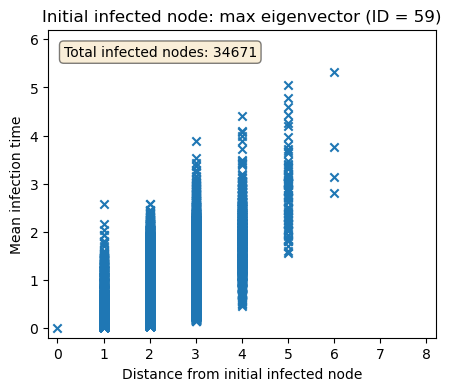

In [6]:
# Find node with highest eigenvector centrality
max_eigenvector_node = max(eigenvector, key=eigenvector.get)
print(f'Max eigenvector node: {(max_eigenvector_node, eigenvector[max_eigenvector_node])}')

# Simulate SI epidemic with max eigenvector node as initial infected node
node_distance_time = simulate_si(G, tau=1, initial_infected=max_eigenvector_node, nruns=10)

# Print total number of infected nodes
print(f'Total number of infected nodes: {len(node_distance_time)}')

# Plot mean infection time as a function of distance from initial infected node
plot_distance_time(node_distance_time, max_eigenvector_node, 'max eigenvector', save=True)

Min eigenvector node: (858, 1.5684687372311454e-20)
Total number of infected nodes: 2


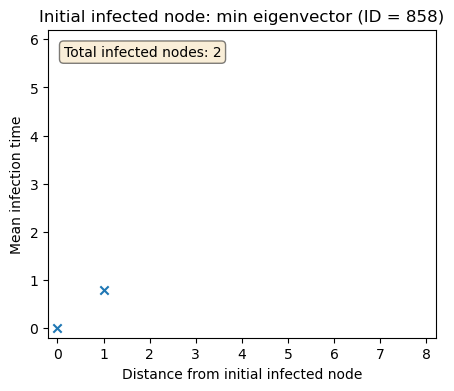

In [7]:
# Find node with lowest eigenvector centrality
min_eigenvector_node = min(eigenvector, key=eigenvector.get)
print(f'Min eigenvector node: {(min_eigenvector_node, eigenvector[min_eigenvector_node])}')

# Simulate SI epidemic with min eigenvector node as initial infected node
node_distance_time = simulate_si(G, tau=1, initial_infected=min_eigenvector_node, nruns=10)

# Print total number of infected nodes
print(f'Total number of infected nodes: {len(node_distance_time)}')

# Plot mean infection time as a function of distance from initial infected node
plot_distance_time(node_distance_time, min_eigenvector_node, 'min eigenvector', save=True)

## Betweenness centrality
Betweenness centrality is an important metric because a node with high betweenness centrality is likely to be a bridge between different parts of the network. In an epidemic spreading model, this means that such nodes are likely to lie on the paths of infection between different groups of nodes, making them important in terms of controlling the spread of the epidemic.

In [8]:
# Import node betweenness centralities
with open('data/task2/betweenness_centrality.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    betweenness = {int(row[0]): float(row[1]) for row in reader}

Max betweenness node: (59, 0.11404735670207757)
Total number of infected nodes: 34671


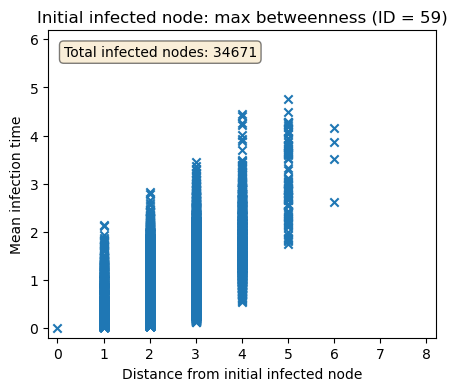

In [9]:
# Find node with highest betweenness centrality
max_betweenness_node = max(betweenness, key=betweenness.get)
print(f'Max betweenness node: {(max_betweenness_node, betweenness[max_betweenness_node])}')

# Simulate SI epidemic with max betweenness node as initial infected node
node_distance_time = simulate_si(G, tau=1, initial_infected=max_betweenness_node, nruns=10)

# Print total number of infected nodes
print(f'Total number of infected nodes: {len(node_distance_time)}')

# Plot mean infection time as a function of distance from initial infected node
plot_distance_time(node_distance_time, max_betweenness_node, 'max betweenness', save=True)

Min betweenness node: (12, 0.0)
Total number of infected nodes: 34671


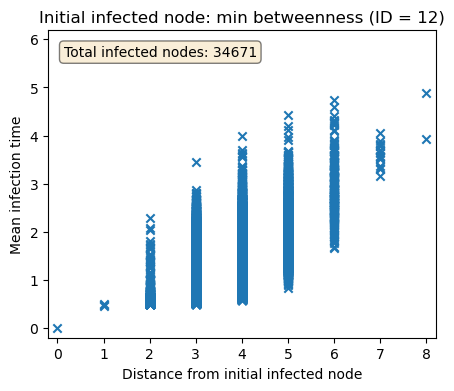

In [10]:
# Find node with lowest betweenness centrality
min_betweenness_node = min(betweenness, key=betweenness.get)
print(f'Min betweenness node: {(min_betweenness_node, betweenness[min_betweenness_node])}')

# Simulate SI epidemic with min betweenness node as initial infected node
node_distance_time = simulate_si(G, tau=1, initial_infected=min_betweenness_node, nruns=10)

# Print total number of infected nodes
print(f'Total number of infected nodes: {len(node_distance_time)}')

# Plot mean infection time as a function of distance from initial infected node
plot_distance_time(node_distance_time, min_betweenness_node, 'min betweenness', save=True)

## Final result

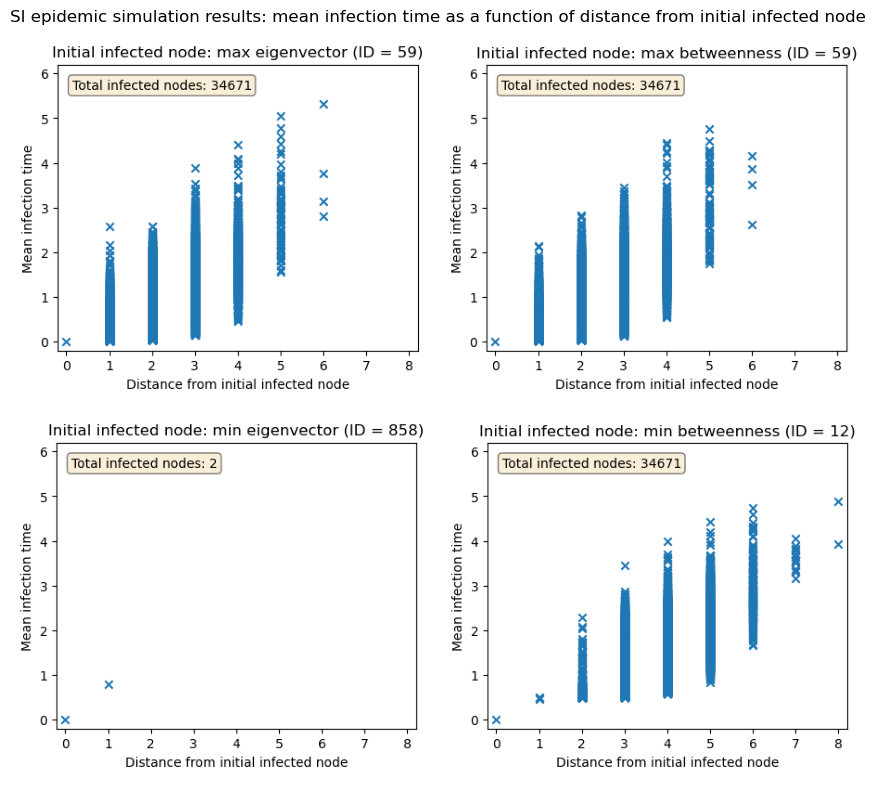

In [11]:
# Combine result plots into one figure
fig_max_eigenvector = plt.imread('results/task2/max_eigenvector.png')
fig_min_eigenvector = plt.imread('results/task2/min_eigenvector.png')
fig_max_betweenness = plt.imread('results/task2/max_betweenness.png')
fig_min_betweenness = plt.imread('results/task2/min_betweenness.png')

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('SI epidemic simulation results: mean infection time as a function of distance from initial infected node')

axes[0, 0].imshow(fig_max_eigenvector)
axes[0, 0].axis('off')
axes[1, 0].imshow(fig_min_eigenvector)
axes[1, 0].axis('off')
axes[0, 1].imshow(fig_max_betweenness)
axes[0, 1].axis('off')
axes[1, 1].imshow(fig_min_betweenness)
axes[1, 1].axis('off')

fig.tight_layout()
fig.subplots_adjust(wspace=-0.2)

# Save figure
fig.savefig('results/task2/combined.png', dpi=fig.dpi, bbox_inches='tight')

plt.show()
